In [15]:
# Load Python libraries
from sklearn import cross_validation, grid_search, metrics, ensemble
#import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb

print('Loading data...')
train = pd.read_csv('train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
test = pd.read_csv('test.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})
songs = pd.read_csv('songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv('members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'})
songs_extra = pd.read_csv('song_extra_info.csv')

print("Done loading")


Loading data...
Done loading


In [6]:
print('Data preprocessing...')
song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
train = train.merge(songs[song_cols], on='song_id', how='left')
test = test.merge(songs[song_cols], on='song_id', how='left')

members['reg_year'] = members['registration_init_time'].apply(lambda x: int(str(x)[0:4]))
members['reg_month'] = members['registration_init_time'].apply(lambda x: int(str(x)[4:6]))
members['reg_date'] = members['registration_init_time'].apply(lambda x: int(str(x)[6:8]))

members['exp_year'] = members['expiration_date'].apply(lambda x: int(str(x)[0:4]))
members['exp_month'] = members['expiration_date'].apply(lambda x: int(str(x)[4:6]))
members['exp_date'] = members['expiration_date'].apply(lambda x: int(str(x)[6:8]))
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')

print("Done preprocessing")

Data preprocessing...
Done preprocessing


In [8]:
df = train
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d')
df.expiration_date = pd.to_datetime(df.expiration_date, format='%Y%m%d')
train = train.drop(['expiration_date'],axis=1)

In [13]:
df.shape

(7377418, 19)

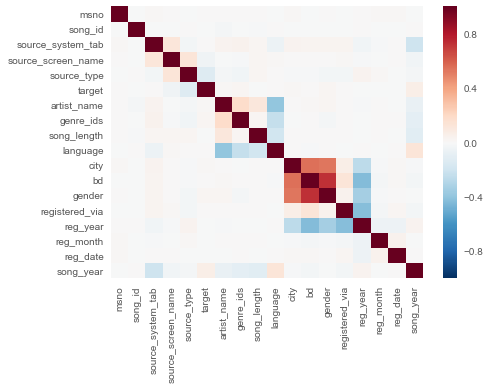

In [18]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes
    
# Correlation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [33]:
## some visualization

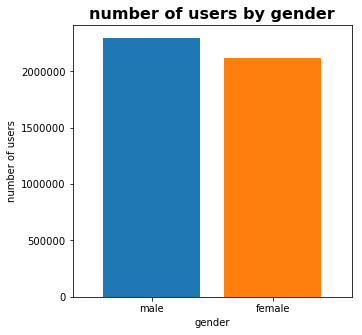

In [45]:
df_gender = train.gender.value_counts().reset_index()
df_gender.gender.plot.bar(figsize=(5, 5), width=0.8, color=['C0','C1'])
plt.xticks(np.arange(2), ['male', 'female'], rotation=0)
plt.ylabel('number of users')
plt.xlabel('gender')
plt.title('number of users by gender', fontsize=16, fontweight='bold')


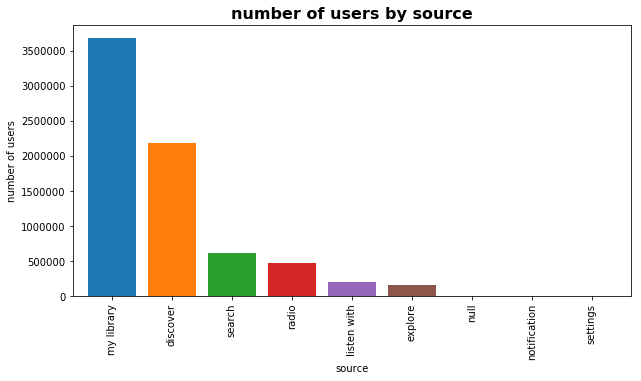

In [52]:
df_source = train.source_system_tab.value_counts().reset_index()
df_source.source_system_tab.plot.bar(figsize=(10, 5), width=0.8, color=['C0','C1','C2','C3','C4','C5','C6','C7','C8'])
plt.xticks(np.arange(9), ['my library', 'discover', 'search','radio','listen with','explore','null','notification','settings'])
plt.ylabel('number of users')
plt.xlabel('source')
plt.title('number of users by source', fontsize=16, fontweight='bold')

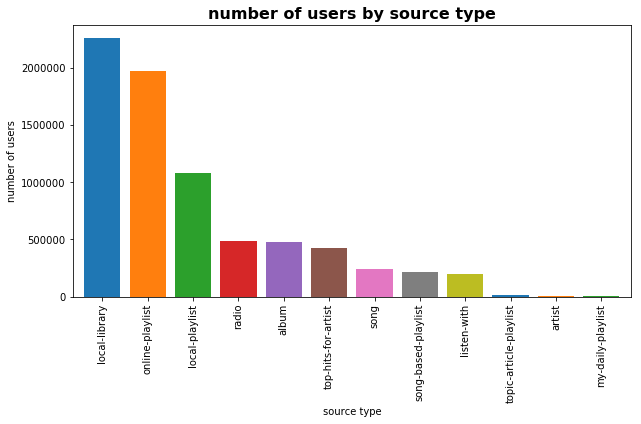

In [58]:
df_source_type = train.source_type.value_counts().reset_index()
df_source_type.source_type.plot.bar(figsize=(10, 5), width=0.8, color=['C0','C1','C2','C3','C4','C5','C6','C7','C8'])
plt.xticks(np.arange(12), df_source_type['index'])
plt.ylabel('number of users')
plt.xlabel('source type')
plt.title('number of users by source type', fontsize=16, fontweight='bold')

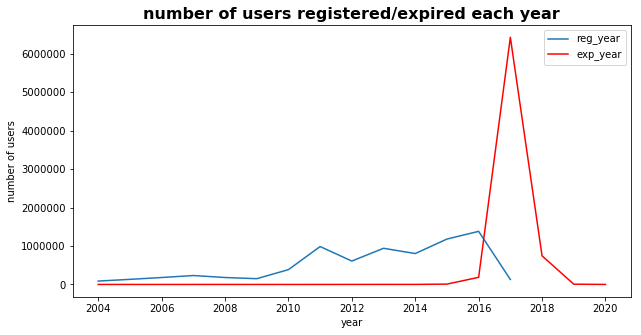

In [98]:
df_reg_year=train.reg_year.value_counts().reset_index()
df_reg_year=df_reg_year.sort_values(by=['index'],ascending=True)
#plt.plot(df_reg_year['index'],df_reg_year.reg_year)

df_exp_year=train.exp_year.value_counts().reset_index()
df_exp_year=df_exp_year.sort_values(by=['index'],ascending=True)
df_exp_year=df_exp_year[1:]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_reg_year['index'],df_reg_year.reg_year, '-')
ax.plot(df_exp_year['index'],df_exp_year.exp_year, 'r-')
ax.set_ylabel('number of users')
ax.set_xlabel('year')
ax.set_title('number of users registered/expired each year', fontsize = 16, fontweight = 'bold')
plt.legend()


In [8]:
df_exp_date=df.expiration_date.value_counts().reset_index()
df_exp_date=df_exp_date.sort_values(by=['index'],ascending=True)


In [19]:
df_reg_date=df.registration_init_time.value_counts().reset_index()
df_reg_date=df_reg_date.sort_values(by=['index'],ascending=True)


In [27]:
df_exp_date=df_exp_date[1:]

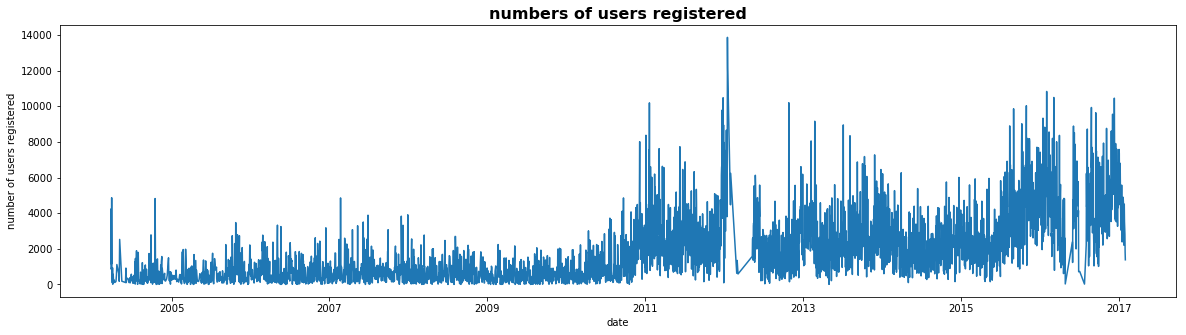

In [34]:
fig,ax = plt.subplots(figsize=(20,5))
ax.plot(df_reg_date['index'],df_reg_date.registration_init_time, '-')
#ax.plot(df_exp_date['index'],df_exp_date.expiration_date,'r-')
ax.set_ylabel('number of users registered')
ax.set_xlabel('date')
ax.set_title('numbers of users registered', fontsize = 16, fontweight = 'bold')


In [35]:
train.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,registered_via,registration_init_time,expiration_date,reg_year,reg_month,reg_date,exp_year,exp_month,exp_date,song_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,206471.0,52.0,...,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5,2016.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,284584.0,52.0,...,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11,1999.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,225396.0,52.0,...,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11,2006.0


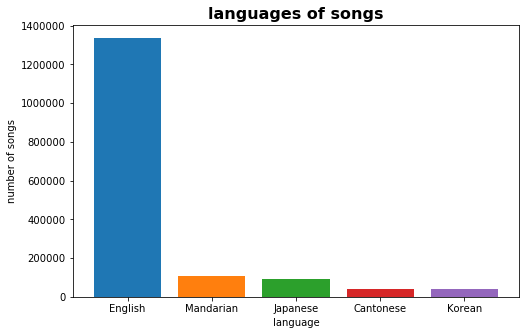

In [85]:
df_language = songs.language.value_counts().reset_index()
df_language = df_language.drop([1])
df_language = df_language.head(5)
df_language.language.plot.bar(figsize=(8, 5), width=0.8, color=['C0','C1','C2','C3','C4'])
language = ['English', 'Mandarian', 'Japanese', 'Cantonese', 'Korean']

plt.xticks(np.arange(5), language, rotation=0)
plt.ylabel('number of songs')
plt.xlabel('language')
plt.title('languages of songs', fontsize=16, fontweight='bold')

In [69]:
df_language = df_language.drop([1])

In [3]:
train['2017_songs_frac'] = (train['song_year'] == 2017).rolling(window = 50000, center = True).mean()
test['2017_songs_frac'] = (test['song_year'] == 2017).rolling(window = 50000, center = True).mean()

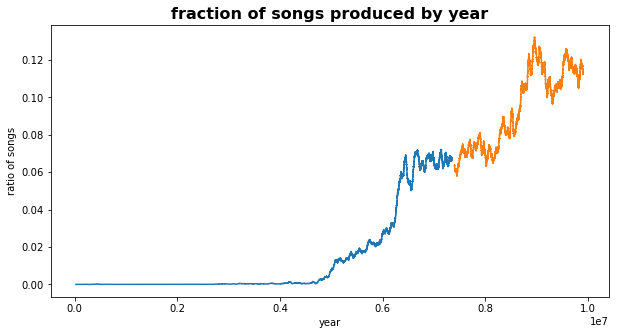

In [5]:
plt.figure(figsize=(10,5))
plt.plot(train.index.values, train['2017_songs_frac'], '-',
        train.shape[0] + test.index.values, test['2017_songs_frac'], '-');

plt.ylabel('fraction of songs')
plt.xlabel('year')
plt.title('fraction of songs released by year', fontsize=16, fontweight='bold')

In [7]:
train


,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,genre_ids,song_length,language,...,bd,gender,registered_via,registration_init_time,expiration_date,reg_year,reg_month,reg_date,song_year,2017_songs_frac
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,Bastille,359,206471.0,52.0,...,0,NaN,7,20120102,20171005,2012,1,2,2016.0,NaN
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,Various Artists,1259,284584.0,52.0,...,24,female,9,20110525,20170911,2011,5,25,1999.0,NaN
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,Nas,1259,225396.0,52.0,...,24,female,9,20110525,20170911,2011,5,25,2006.0,NaN
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,Soundway,1019,255512.0,-1.0,...,24,female,9,20110525,20170911,2011,5,25,2010.0,NaN
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,Brett Young,1011,187802.0,52.0,...,0,NaN,7,20120102,20171005,2012,1,2,2016.0,NaN
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,Desiigner,1259,247803.0,52.0,...,0,NaN,7,20120102,20171005,2012,1,2,2016.0,NaN
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1,BIGBANG TAEYANG,465,229982.0,31.0,...,24,female,9,20110525,20170911,2011,5,25,2014.0,NaN
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,Thomas Rhett,1011,181115.0,52.0,...,0,NaN,7,20120102,20171005,2012,1,2,2016.0,NaN
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1,OneRepublic,2022,278964.0,52.0,...,26,male,9,20111107,20180304,2011,11,7,2007.0,NaN
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1,OneRepublic,465,257369.0,52.0,...,26,male,9,20111107,20180304,2011,11,7,2013.0,NaN


In [6]:
import gc
del members, songs; gc.collect();

for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

X = train.drop(['target'], axis=1)
y = train['target'].values

X_test = test.drop(['id'], axis=1)
ids = test['id'].values

del train, test; gc.collect();

d_train = lgb.Dataset(X, y)
watchlist = [d_train]

In [8]:

print('Training LGBM model...')
params = {}
params['learning_rate'] = 0.8
params['application'] = 'binary'
params['max_depth'] = 10
params['num_leaves'] = 2**10
params['verbosity'] = 0
params['metric'] = 'auc'

model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist, \
verbose_eval=5)

print('Making predictions and saving them...')
p_test = model.predict(X_test)

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test
subm.to_csv('submission2.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
print('Done!')

Training LGBM model...
[5]	training's auc: 0.724133
[10]	training's auc: 0.736387
[15]	training's auc: 0.750494
[20]	training's auc: 0.759877
[25]	training's auc: 0.766438
[30]	training's auc: 0.77381
[35]	training's auc: 0.779209
[40]	training's auc: 0.783955
[45]	training's auc: 0.788471
[50]	training's auc: 0.791137
Making predictions and saving them...
Done!


In [57]:
result = pd.DataFrame()

In [58]:
result

""


In [75]:
auc = []

In [96]:
lgb.evals_result

In [120]:
result  = pd.DataFrame()

In [9]:
auc = []

In [10]:
evals_result = {}
for learning_rate in [0.8]:
    for max_depth in range(10,15):

        print('Training LGBM model...')
        params = {}
        params['learning_rate'] = learning_rate
        params['application'] = 'binary'
        params['max_depth'] = max_depth
        params['num_leaves'] = 2**max_depth
        params['verbosity'] = 0
        params['metric'] = 'auc'

        model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist, \
        verbose_eval=5, evals_result = evals_result)
        
        
        print('Making predictions and saving them...')
        
       # p_test = model.predict(X_test)
        #subm = pd.DataFrame()
        #subm['id'] = ids
        #subm['target'] = p_test
    
        #aresult[str(learning_rate) + ',' + str(max_depth)] = subm['target']
        
        auc.append(evals_result['training']['auc'][-1])
print(auc)

Training LGBM model...
[5]	training's auc: 0.724133
[10]	training's auc: 0.736387
[15]	training's auc: 0.750494
[20]	training's auc: 0.759877
[25]	training's auc: 0.766438
[30]	training's auc: 0.77381
[35]	training's auc: 0.779209
[40]	training's auc: 0.783955
[45]	training's auc: 0.788471
[50]	training's auc: 0.791137
Making predictions and saving them...
Training LGBM model...
[5]	training's auc: 0.725117
[10]	training's auc: 0.74154
[15]	training's auc: 0.753866
[20]	training's auc: 0.762324
[25]	training's auc: 0.770754
[30]	training's auc: 0.777436
[35]	training's auc: 0.782073
[40]	training's auc: 0.786585
[45]	training's auc: 0.79081
[50]	training's auc: 0.794553
Making predictions and saving them...
Training LGBM model...
[5]	training's auc: 0.728932
[10]	training's auc: 0.744903
[15]	training's auc: 0.758599
[20]	training's auc: 0.769791
[25]	training's auc: 0.77671
[30]	training's auc: 0.782989
[35]	training's auc: 0.788072
[40]	training's auc: 0.792767
[45]	training's auc: 0

In [ ]:
for index, row in result.iterrows():
    vec = result.iloc[index]
    prob.append(np.dot(vec,auc)/sum(auc))

In [ ]:
print('Tuning parameters...')
params = {}
params['learning_rate'] = 0.8
params['application'] = 'binary'
params['max_depth'] = 15
params['num_leaves'] = 2**15
params['verbosity'] = 0
params['metric'] = 'auc'

print('Training LGBM model...')

model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist, \
    verbose_eval=5)

print('Making predictions and saving them...')
p_test = model.predict(X_test)

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test
    
#result[str(learning_rate) + ',' + str(max_depth)] = subm['target']
#result = pd.concat([result,subm['target']],1)


subm.to_csv('0.8_14.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
print('Done!')

Training LGBM model...


In [4]:
print('Tuning parameters...')
params = {}
params['learning_rate'] = 0.6
params['application'] = 'binary'
params['max_depth'] = 11
params['num_leaves'] = 2**11
params['verbosity'] = 0
params['metric'] = 'auc'

print('Training LGBM model...')

model = lgb.train(params, train_set=d_train, num_boost_round=50, valid_sets=watchlist, \
    verbose_eval=5)

print('Making predictions and saving them...')
p_test = model.predict(X_test)

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test
    
#result[str(learning_rate) + ',' + str(max_depth)] = subm['target']
#result = pd.concat([result,subm['target']],1)


subm.to_csv('0.6_11.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')
print('Done!')

Tuning parameters...
Training LGBM model...
[5]	training's auc: 0.730455
[10]	training's auc: 0.745076
[15]	training's auc: 0.754963
[20]	training's auc: 0.762592
[25]	training's auc: 0.770115
[30]	training's auc: 0.77513
[35]	training's auc: 0.780194
[40]	training's auc: 0.783923
[45]	training's auc: 0.788356
[50]	training's auc: 0.791459
Making predictions and saving them...
Done!
